## Table of content

1. [bproperty assessment](#bproperty-assessment) -> [Report summary](#bproperty-assessment-report)
1. [bproperty cleaning](#bproperty-cleaning)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from slugify import slugify
import os

%matplotlib inline

In [2]:
# CSV folders

raw_data_folder="../../../data/Raw_Data"
cleaned_data_folder="../../../data/CLeaned_Data"

bproperty_folder= f"{raw_data_folder}/bproperty_spider"
cleaned_bproperty_folder= f"{cleaned_data_folder}/bproperty"

In [3]:
target_df_dic = {
    "area":[],  # value in float, in sqft; 1 Katha = 720 sqft (Thanks @Kausthab Dutta Phukan)
    "building_type":[],
    "building_nature": [], # originally named commercial_type; value will be either Commercial or Residential
    
    # splitted from location column
    "city": [],
    "address":[],
    #"country": [],
    #"municipality":[],
    #"district":[],
    #...
    #"otherZoneArea":[], # create new column for any new zone information, and keep collaborators informed
    
    
    "num_bath_rooms":[], # for Commercial properties, give 0 as value (since that make sense), not NaN
    "num_bed_rooms":[], # for Commercial properties, give 0 as value (since that make sense), not NaN
    
    # convert currencies to BDT : 1 lakh=100000 BDT, 1 crore=10000000 BDT, 1 Arab= 1000000000 BDT (Thanks @Al Momin Faruk)
    "price": [], 
    
    "property_description":[],
    "property_overview":[],
    
    "purpose":[], # Either Rent/Sale
    
    # retrieved from amenities column: assuming in sample 1 amenities has {"k1":"v1","k2":"v2"} 
    #   and in sample 2 amenities has {"k3":"v3"}, we create new columns in the dataframe based on the keys of
    #   the dictionnaries
    "k1":[],
    "k2":[],
    "k3":[],
    
    # when any relevant column from other csv files is added, inform collaborators so that they follow the same principle
}

target_df = pd.DataFrame(target_df_dic)
target_df.T

""
area
building_type
building_nature
city
address
num_bath_rooms
num_bed_rooms
price
property_description
property_overview


<span id="bproperty-assessment"> </span>

## Assessing `bproperty_spider_2023-04-09T19-44-07`

In [4]:
bproperty_df=pd.read_csv(f"{bproperty_folder}/bproperty_spider_2023-04-14T18-31-56.csv")
bproperty_df.head().T

,0,1,2,3,4
amenities,"{'Flooring': 'yes', 'Parking Spaces': ' 1', 'B...",NaN,"{'View': 'yes', 'Balcony or Terrace': 'yes', '...","{'View': 'yes', 'Balcony or Terrace': 'yes', '...","{'View': 'yes', 'Balcony or Terrace': 'yes', '..."
area,"1,265 sqft","4,400 sqft","1,160 sqft","1,185 sqft",970 sqft
building_type,Apartment,Apartment,Apartment,Apartment,Apartment
commercial_type,False,False,False,False,False
location,"Baridhara DOHS, Dhaka","Gulshan 2, Gulshan, Dhaka","Khilgaon, Dhaka","Khilgaon, Dhaka","Khilgaon, Dhaka"
num_bath_rooms,3 Baths,4 Baths,NaN,NaN,NaN
num_bed_rooms,3 Beds,4 Beds,3 Beds,3 Beds,2 Beds
price,1.25 Crore,7.04 Crore,62 Lakh,61 Lakh,52 Lakh
property_description,Ready Flat Of 1265 Sq Ft Is Now Up For Sale In...,You Can Move Into This Well Planned And Comfor...,"Buy This 1160 Sq Ft Flat In Khilgaon, South Goran","1185 Sq Ft Flat Is Up For Sale In South Goran,...",Relax In This 970 Sq Ft Flat For Sale In South...
property_overview,Looking for a luxurious apartment with top-not...,"Amicable environment, appropriate commuting sy...","A lively area to live, lovely home to settle a...","Considering a suitable lifestyle, this is one ...",Are you concerned about finding a home which w...


In [5]:
bproperty_df.shape

(17256, 12)

In [6]:
bproperty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   amenities             16367 non-null  object
 1   area                  17256 non-null  object
 2   building_type         17256 non-null  object
 3   commercial_type       17256 non-null  bool  
 4   location              17256 non-null  object
 5   num_bath_rooms        5681 non-null   object
 6   num_bed_rooms         12574 non-null  object
 7   price                 17256 non-null  object
 8   property_description  17256 non-null  object
 9   property_overview     17256 non-null  object
 10  property_url          17256 non-null  object
 11  purpose               17256 non-null  object
dtypes: bool(1), object(11)
memory usage: 1.5+ MB


* `area` column should be decimal, not string (quality issue)
* Replace column name `commercial_type` by `building_nature` (or any relevant name), and change its values to `residential` or `commercial` accordingly.  (quality issue)
* `location` is has concatened information: city, district, sector, etc. Those informations should be splitted in their relevant columns (column `city`, column `district`, ...). (tidiness issue)
* `num_bath_rooms` and `num_bed_rooms` should be decimal, no string. (quality issue)


In [7]:
bproperty_df["price"].unique()

array(['1.25 Crore', '7.04 Crore', '62 Lakh', ..., '13.98 Lakh',
       '96.25 Lakh', '92.1 Lakh'], dtype=object)

* `price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. A special attention should be paid to the fact that there are `price` without unit (a solution need to be found for them). (quality issue)
* `price` should be decimal, not string

In [8]:
bproperty_df["property_description"][0]

'Ready Flat Of 1265 Sq Ft Is Now Up For Sale In Baridhara Dohs'

In [9]:
bproperty_df["property_description"][15]

'This 1,350 SQ FT Marvelous and Prominent Office Space For Rent Is Available Close To Crescent Hospital In Uttara'

In [10]:
bproperty_df["property_overview"][0]

"Looking for a luxurious apartment with top-notch amenities and easy access to all the essential facilities you need? This stunning 3-bedroom, 3-bathroom apartment in the heart of Baridhara DOHS is a rare find. With 1,265 sqft of living space, this home boasts 2 balconies, a drawing room, a dining area, and a modern kitchen with all the latest fittings. With an attendant's bathroom, electricity backup, community space, parking space, CCTV security, visitor log, security staff, and beautiful interior, this apartment is sure to impress. But what truly sets this home apart is its prime location. Baridhara DOHS is one of the most sought-after areas in Dhaka, and for good reason. Residents enjoy easy access to top-notch educational institutions, including Baridhara Scholars Institution and the American International School Dhaka. There are also several healthcare facilities in the area, such as United Hospital and Upasham Hospital, ensuring that residents can receive quality medical care wh

In [11]:
bproperty_df["property_overview"][150]

'An open floor is up for rent in the busiest suburb of Dhanmondi. The floor can be a perfect opportunity to expand your business or open a new branch in Dhanmondi area. With an area of the business space makes sure you get all the upgraded necessary facilities. For a business, an easily accessible location is very important. And finding such space in a location like Dhanmondi is really difficult, that too on a budget. But this wonderfully organized space of 4235  Square Feet can be an amazing option both in terms of location and accessibility. Book this space and make a wise choice which also comes within your affordability.'

In [12]:
property_per_purpose = bproperty_df["purpose"].value_counts()
property_per_purpose

For Sale    10905
For Rent     6351
Name: purpose, dtype: int64

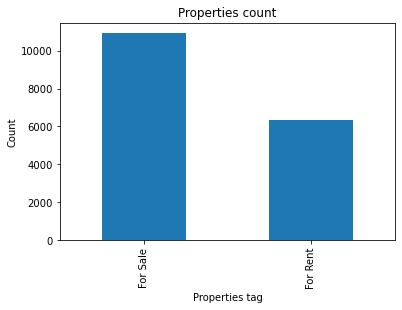

In [13]:
property_per_purpose.plot(kind="bar")
plt.xlabel("Properties tag")
plt.ylabel("Count")
plt.title("Properties count");

Properties for sale are nearly the double of the properties for rent. And the amount of properties may be a little low to make the futures model predict well on unknow data.

In [14]:
bproperty_df["amenities"][0]

"{'Flooring': 'yes', 'Parking Spaces': ' 1', 'Balcony or Terrace': 'yes', 'Floor Level': 'yes', 'View': 'yes', 'Elevators in Building': ' 1', 'Lobby in Building': 'yes'}"

In [15]:
bproperty_df["amenities"][220]

"{'View': 'yes', 'Floor Level': 'yes', 'Balcony or Terrace': 'yes', 'Flooring': 'yes', 'Central Heating': 'yes', 'Elevators in Building': ' 1', 'Parking Spaces': ' 1', 'Lobby in Building': 'yes', 'Freehold': 'yes', 'Electricity Backup': 'yes', '24 Hours Concierge': 'yes', 'Intercom': 'yes', 'CCTV Security': 'yes', 'Maintenance Staff': 'yes'}"

Each key in the dictionary of the feature `amenities` should become a column, with the following indications:
* `Floor level`: should be of type integer; its content should be the number of floor of the property
* `View`: should be of type boolean
* `Balcony or Terrace`: column should be named `balcony-or-terrace`, and should be of type boolean
* `Flooring`: should be of type boolean
* `Electricity backup`: column should be named `electricity-backup`, and should be of type boolean
* `Elevators in Buildings`: column should be named `elevator`, and should be of type int
* `Broadband Internet`: column should be named `internet`, and content should be boolean
* `CCTV Security`: column should be named `cctv-security`, and should be boolean
* `Cleaning Services`: column should be named `cleaning-services`, and should be boolean
* Keys present in the dictionary but not mentioned in the above list should also become a column

(tidiness issues)

In [16]:
bproperty_df["building_type"].unique()

array(['Apartment', 'Office', 'Floor', 'Building', 'Plot', 'Shop',
       'Duplex', 'Warehouse', 'Factory'], dtype=object)

In [17]:
bproperty_df["purpose"].unique()

array(['For Sale', 'For Rent'], dtype=object)

`purpose` should have `Rent` or `Sale` as values, to keep all cleaned datasets consistent.

<span id="bproperty-assessment-report"> </span>

#### Assessment report summary

##### Quality issues
1. `area` column should be decimal, not string.
1. Replace column name `commercial_type` by `building_nature`, and change its values to `residential` or `commercial` accordingly.
1. `num_bath_rooms` and `num_bed_rooms` should be decimal, no string.
1. `price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. Please pay attention to the fact that there are `price` without unit.
1. `price` should be decimal, not string
1. `purpose` should have `Rent` or `Sale` as values. This is not really an issue, its goal is only to keep values consistent accross all cleaned datasets.


##### Tidiness issues
1. `location` has concatened informations: city, district, sector, etc. Those informations will be splitted into `city` and `address`..
1. In `amenities` feature, each key in the dictionary should become a column, with the following indications:
    * `Floor level`:  column should be named `floor-level`, and should be of type integer; its content should be the number of floor of the property ??
    * `View`: should be of type boolean
    * `Balcony or Terrace`: column should be named `balcony-or-terrace`, and should be of type boolean
    * `Flooring`: should be of type boolean
    * `Electricity backup`: column should be named `electricity-backup`, and should be of type boolean
    * `Elevators in Buildings`: column should be named `elevator`, and should be of type int
    * `Broadband Internet`: column should be named `internet`, and content should be boolean
    * `CCTV Security`: column should be named `cctv-security`, and should be boolean
    * `Cleaning Services`: column should be named `cleaning-services`, and should be boolean
    * Keys present in the dictionary but not mentioned in the above list should also become a column
    

<span id="bproperty-cleaning"> </span>

## Cleaning `bproperty`

### `area` column should be decimal, not string ( [quality issue #1](#bproperty-assessment-report) )

In [18]:
# Recalling the type of area feature
bproperty_df["area"].dtype

dtype('O')

In [19]:
bproperty_df["area"].unique()

array(['1,265 sqft', '4,400 sqft', '1,160 sqft', ..., '233 sqft',
       '185 sqft', '307 sqft'], dtype=object)

There are value in `sqft` and in `Katha`

#### Define
* Loop through `area` column, while:
    * converting `Katha` value to `sqft` value
    * removing the unit in the value, to only have the number left
* Convert `area` column to decimal

#### Code

In [20]:
"""
    Loop through `area` column, while:
        - converting `Katha` value to `sqft` value
        - removing the unit in the value, to only have the number left
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # retrieve the area
    sample_area = bproperty_df.loc[index, "area"] 
    splitted_sample_area = sample_area.split()
    
    # making sure there is only the value and the unit in sample_area
    if len(splitted_sample_area)>2:
        print(f"Sample of index {index} has a suspicious value as area: {sample_area}")
        break
        
    area = float( splitted_sample_area[0].replace(",","") ) # will contain the area; eg: 1345
    area_unit = splitted_sample_area[1].lower() # will contain the unit; eg: sqft
    
    # making sure all units are taken into account
    if area_unit not in ["sqft","katha"]:
        print(f"Sample of index {index} has a unit not taken into account for its area: {sample_area}")
        break
   
    # converting katha area to sqft area (1 Katha = 720 sqft => Thanks @Kausthab Dutta Phukan )
    if area_unit=="katha":
        area *= 720
        
    # updating the area of the sample in the dataframe
    bproperty_df.loc[index, "area"] = area
    
print("Processing has come to an end")

# Converting area to decimal
bproperty_df["area"] = bproperty_df["area"].astype(float)

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...
Processing has come to an end


#### Testing

In [21]:
bproperty_df["area"].dtype

dtype('float64')

### Cleaning `commercial_type` feature ( [quality issue #2](#bproperty-assessment-report) )

Replace column name `commercial_type` by `building_nature`, and change its values to `residential` or `commercial` accordingly.

In [22]:
bproperty_df["commercial_type"].unique()

array([False,  True])

#### Define
* Change column values: `True` is to be updated to `Commercial`, and `False` is to become `Residential`
* Replace column name (`commercial_type`) by `building_nature`

#### Code

In [23]:
# Replacing values of commercial_type column
bproperty_df.loc[ bproperty_df["commercial_type"]==True, ["commercial_type"] ] = "Commercial"
bproperty_df.loc[ bproperty_df["commercial_type"]==False, ["commercial_type"] ] = "Residential"

# Making sure values were updated
bproperty_df["commercial_type"].unique()

array(['Residential', 'Commercial'], dtype=object)

In [24]:
# Renaming column
bproperty_df.rename(columns={
    "commercial_type":"building_nature"
}, inplace=True)

# Confirming rename was done
bproperty_df.columns.to_list()

['amenities',
 'area',
 'building_type',
 'building_nature',
 'location',
 'num_bath_rooms',
 'num_bed_rooms',
 'price',
 'property_description',
 'property_overview',
 'property_url',
 'purpose']

In [25]:
# Taking a look at content (for general confirmation)
bproperty_df.head(2).T

,0,1
amenities,"{'Flooring': 'yes', 'Parking Spaces': ' 1', 'B...",NaN
area,1265.0,4400.0
building_type,Apartment,Apartment
building_nature,Residential,Residential
location,"Baridhara DOHS, Dhaka","Gulshan 2, Gulshan, Dhaka"
num_bath_rooms,3 Baths,4 Baths
num_bed_rooms,3 Beds,4 Beds
price,1.25 Crore,7.04 Crore
property_description,Ready Flat Of 1265 Sq Ft Is Now Up For Sale In...,You Can Move Into This Well Planned And Comfor...
property_overview,Looking for a luxurious apartment with top-not...,"Amicable environment, appropriate commuting sy..."


### `num_bath_rooms` and `num_bed_rooms` should be integer, no string. ( [quality issue #3](#bproperty-assessment-report) )

In [26]:
bproperty_df["num_bath_rooms"].dtype

dtype('O')

In [27]:
bproperty_df["num_bath_rooms"].unique()

array(['3 Baths', '4 Baths', nan, '2 Baths', '10 Baths', '5 Baths',
       '8 Baths', '1 Bath', '7 Baths', '6 Baths', '9 Baths'], dtype=object)

In [28]:
bproperty_df["num_bed_rooms"].dtype

dtype('O')

In [29]:
bproperty_df["num_bed_rooms"].unique()

array(['3 Beds', '4 Beds', '2 Beds', nan, '21 Beds', '5 Beds', '7 Beds',
       '1 Bed', '6 Beds', '19 Beds', '24 Beds', '33 Beds', '56 Beds',
       '10 Beds', '13 Beds', '48 Beds', '12 Beds', '60 Beds', '18 Beds',
       '40 Beds', '29 Beds', '23 Beds', '8 Beds', '75 Beds', '14 Beds',
       '50 Beds', '42 Beds', '16 Beds', '36 Beds', '15 Beds', '25 Beds',
       '22 Beds', '46 Beds', '32 Beds', '30 Beds', '11 Beds', '94 Beds',
       '17 Beds', '20 Beds'], dtype=object)

#### Define
* Replace `NaN` values by `0` (since in this case, that made sense: it mean the sample doesn't have a bath_room or bed_room 
* Remove `Bed`, `Beds`, `Bath` and `Baths` from the values of `num_bed_rooms` and `num_bath_rooms`
* Convert `num_bed_rooms` and `num_bath_rooms` to integer

#### Code

In [30]:
# Replace NaN value by 0 in num_bed_rooms and num_bath_rooms
bproperty_df["num_bed_rooms"].fillna("0", inplace=True)
bproperty_df["num_bath_rooms"].fillna("0", inplace=True)

# Check that NaN values where replaced
bproperty_df["num_bed_rooms"].isnull().sum(), bproperty_df["num_bath_rooms"].isnull().sum()

(0, 0)

In [31]:
# Removing the units (bed, bath, ...) in num_bed_rooms and num_bath_rooms
bproperty_df["num_bed_rooms"] = bproperty_df["num_bed_rooms"].apply(lambda x: x.split(" ")[0] )
bproperty_df["num_bath_rooms"] = bproperty_df["num_bath_rooms"].apply(lambda x: x.split(" ")[0] )

In [32]:
# Converting num_bed_rooms and num_bath_rooms to integer
bproperty_df["num_bed_rooms"] = bproperty_df["num_bed_rooms"].astype(int)
bproperty_df["num_bath_rooms"] = bproperty_df["num_bath_rooms"].astype(int)


#### Testing

In [33]:
# Checking type conversion was succesful
bproperty_df["num_bed_rooms"].dtype, bproperty_df["num_bath_rooms"].dtype

(dtype('int32'), dtype('int32'))

### `price` content is not uniform accross the dataset ( [quality issue #4 & #5](#bproperty-assessment-report) )

`price` content is not uniform accross the dataset. Some are in `Lakh`, other in `Crore`, etc... The unit used for the price should be uniformized. A special attention should be paid to the fact that there are `price` without unit.  

Furthermore, `price` should be decimal, not string.

In [34]:
bproperty_df["price"].unique()

array(['1.25 Crore', '7.04 Crore', '62 Lakh', ..., '13.98 Lakh',
       '96.25 Lakh', '92.1 Lakh'], dtype=object)

#### Define
* Convert all price to the same currency
* Replace `Thousand` by triple `0`
* Convert the column to float

#### Code

In [35]:
"""
    Loop through `price` column, while:
        * Converting all prices to BDT currency
        * Replacing `Thousand` by triple `0`
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # retrieve the price
    sample_price = bproperty_df.loc[index, "price"]
    splitted_sample_price= sample_price.split()
    
    # making sure there are only the value and unit in sample price
    if len(splitted_sample_price)>2:
        print(f"Sample of index {index} has a suspicious value as price: {sample_price}")
        break
        
    price = float( splitted_sample_price[0] ) # will contain the price; eg: 1345
    price_unit = splitted_sample_price[1].lower() # will contain the unit; eg: Lakh, Crore
    
    # making sure all units are taken into account
    if price_unit not in ["arab","crore","lakh","thousand"]:
        print(f"Sample of index {index} has a unit not taken into account for its price: {sample_price}")
        break
    
    # converting all price unit to BDT : 1 lakh=100000 BDT,1 crore=10000000 BDT, 1 Arab= 1000000000 BDT (Thanks @Al Momin Faruk)
    if price_unit=="arab":
        price *= 1000000000
    elif price_unit=="crore":
        price *= 10000000
    elif price_unit=="lakh":
        price *= 100000
    elif price_unit=="thousand":
        price *= 1000
    else:
        raise Exception(f"Currency {price_unit} not taken to account")
    
    # updating the price of the sample in the dataframe
    bproperty_df.loc[index, "price"] = price

print("Processing has come to an end")
    
# Converting area to decimal
bproperty_df["price"] = bproperty_df["price"].astype(float)

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...
Processing has come to an end


#### Testing

In [36]:
bproperty_df["price"].dtype

dtype('float64')

### Set `purpose` values to `Rent` or `Sale` ( [quality issue #6](#bproperty-assessment-report) )

`purpose` should have `Rent` or `Sale` as values. This is not really an issue, its goal is only to keep values consistent accross all cleaned datasets.

In [37]:
bproperty_df["purpose"].unique()

array(['For Sale', 'For Rent'], dtype=object)

#### Define
* Replace `For Sale` by `Sale`, and `For Rent` by `Rent` 

#### Code

In [38]:
bproperty_df["purpose"] = bproperty_df["purpose"].apply(lambda x: x.split(" ")[1] )

#### Testing

In [39]:
bproperty_df["purpose"].unique()

array(['Sale', 'Rent'], dtype=object)

### Split `location` column content into adequate columns ( [tidiness issue #1](#bproperty-assessment-report) )

`location` has concatened informations: city, district, sector, etc. Those will be splitted into `city` and `address`.

In [40]:
bproperty_df["location"]

0                  Baridhara DOHS, Dhaka
1              Gulshan 2, Gulshan, Dhaka
2                        Khilgaon, Dhaka
3                        Khilgaon, Dhaka
4                        Khilgaon, Dhaka
                      ...               
17251          Darussalam, Mirpur, Dhaka
17252           Meradia, Khilgaon, Dhaka
17253    Block J, Bashundhara R-A, Dhaka
17254    Block G, Bashundhara R-A, Dhaka
17255           Block H, Banasree, Dhaka
Name: location, Length: 17256, dtype: object

#### Define
* Split content of `location` to `city` and `address`
* Remove `location` column

#### Code

In [41]:
# Retrieve city in location
bproperty_df["city"] = bproperty_df["location"].apply(lambda x: x.split(",")[-1].strip() )

# Retrieve address in location
bproperty_df["address"] = bproperty_df["location"].apply(lambda x: ",".join(x.split(",")[:-1]).strip() )

In [42]:
# Checking the content of location, city, and address
bproperty_df[ ["location","city","address"] ] 

,location,city,address
0,"Baridhara DOHS, Dhaka",Dhaka,Baridhara DOHS
1,"Gulshan 2, Gulshan, Dhaka",Dhaka,"Gulshan 2, Gulshan"
2,"Khilgaon, Dhaka",Dhaka,Khilgaon
3,"Khilgaon, Dhaka",Dhaka,Khilgaon
4,"Khilgaon, Dhaka",Dhaka,Khilgaon
...,...,...,...
17251,"Darussalam, Mirpur, Dhaka",Dhaka,"Darussalam, Mirpur"
17252,"Meradia, Khilgaon, Dhaka",Dhaka,"Meradia, Khilgaon"
17253,"Block J, Bashundhara R-A, Dhaka",Dhaka,"Block J, Bashundhara R-A"
17254,"Block G, Bashundhara R-A, Dhaka",Dhaka,"Block G, Bashundhara R-A"


In [43]:
bproperty_df.shape

(17256, 14)

In [44]:
# Drop location column
bproperty_df.drop(["location"], axis=1, inplace=True)

In [45]:
# Making sure removal was successful
bproperty_df.shape

(17256, 13)

### Cleaning `amenities` feature ( [tidiness issue #2](#bproperty-assessment-report) )

In `amenities` feature, each key in the dictionaries (in its content) should become a column. The value of the key should become the sample value corresponding to that column.

In [46]:
bproperty_df["amenities"][0]

"{'Flooring': 'yes', 'Parking Spaces': ' 1', 'Balcony or Terrace': 'yes', 'Floor Level': 'yes', 'View': 'yes', 'Elevators in Building': ' 1', 'Lobby in Building': 'yes'}"

In [47]:
bproperty_df["amenities"][12]

"{'View': 'yes', 'Parking Spaces': ' 1', 'Floor Level': 'yes', 'Balcony or Terrace': 'yes', 'Lobby in Building': 'yes', 'Electricity Backup': 'yes', 'Flooring': 'yes', 'Elevators in Building': ' 1', 'Maintenance Staff': 'yes', 'Cleaning Services': 'yes'}"

#### Define
* Keys in the dictionaries of `amenities` will become new columns in the dataset; the values of the keys will become the new columns values for the corresponding sample.

#### Code

In [48]:
"""
    Loop through `amenities` column, while:
         * Converting the dictionnaries keys to new columns; the values of the keys are becoming
             the new columns values for the corresponding sample
"""

for index, row in bproperty_df.iterrows(): # loop through each sample
    
    # The code may take time, log in the console to keep track of things
    if index==0 or index%1000==0:
        print(f"Currently processing sample {index}...")
        
    # If current sample doen't have amenities, go to the next one
    if pd.isna(bproperty_df.loc[index, "amenities"]):
        continue
    
    # retrieve the amenities
    sample_amenities = str(bproperty_df.loc[index, "amenities"]).replace("'","\"")
    
    amenities_dict = eval(sample_amenities)
    
    # Go through each key in the amenities dictionnary
    for key, value in amenities_dict.items():
        
        # put a suffix to the new column name, so that collaborators know it was generated from amenities feature
        column_name = slugify(key)+"-amenity"
        #print(column_name)
        
        # Create new column based on the key if not already existing
        if column_name not in bproperty_df.columns.to_list():
            bproperty_df[column_name]= np.NaN # Giving NaN as the default value for the column
        
        # Affecting to the new column created, for the current sample, the value of the dictionary's key
        bproperty_df.loc[index, column_name] = value
        

Currently processing sample 0...
Currently processing sample 1000...
Currently processing sample 2000...
Currently processing sample 3000...
Currently processing sample 4000...
Currently processing sample 5000...
Currently processing sample 6000...
Currently processing sample 7000...
Currently processing sample 8000...
Currently processing sample 9000...
Currently processing sample 10000...
Currently processing sample 11000...
Currently processing sample 12000...
Currently processing sample 13000...
Currently processing sample 14000...
Currently processing sample 15000...
Currently processing sample 16000...
Currently processing sample 17000...


In [49]:
# Checking columns
bproperty_df.head(3).T

,0,1,2
amenities,"{'Flooring': 'yes', 'Parking Spaces': ' 1', 'B...",NaN,"{'View': 'yes', 'Balcony or Terrace': 'yes', '..."
area,1265.0,4400.0,1160.0
building_type,Apartment,Apartment,Apartment
building_nature,Residential,Residential,Residential
num_bath_rooms,3,4,0
num_bed_rooms,3,4,3
price,12500000.0,70400000.0,6200000.0
property_description,Ready Flat Of 1265 Sq Ft Is Now Up For Sale In...,You Can Move Into This Well Planned And Comfor...,"Buy This 1160 Sq Ft Flat In Khilgaon, South Goran"
property_overview,Looking for a luxurious apartment with top-not...,"Amicable environment, appropriate commuting sy...","A lively area to live, lovely home to settle a..."
property_url,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...


In [50]:
# Drop amenities column
bproperty_df.drop(["amenities"],axis=1, inplace=True)

# Check that removal was effective
"amenities" in bproperty_df.columns.to_list()

False

### Save cleaned dataset

In [51]:
# Create folder in which to save cleaned dataset
if not os.path.exists(cleaned_bproperty_folder):
    os.makedirs(cleaned_bproperty_folder)
    print(f"Create folder '{cleaned_bproperty_folder}'")
else:
    print(f"Folder '{cleaned_bproperty_folder}' already exists")

Create folder '../../../data/CLeaned_Data/bproperty'


In [52]:
# Save cleaned dataset to csv
bproperty_df.to_csv(f"{cleaned_bproperty_folder}/cleaned_bproperty.csv", index=False)

In [53]:
# Load saved csv (to make sure it was successfully save)
clean_bproperty_df = pd.read_csv(f"{cleaned_bproperty_folder}/cleaned_bproperty.csv")
clean_bproperty_df.head(3).T

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2
area,1265.0,4400.0,1160.0
building_type,Apartment,Apartment,Apartment
building_nature,Residential,Residential,Residential
num_bath_rooms,3,4,0
num_bed_rooms,3,4,3
price,12500000.0,70400000.0,6200000.0
property_description,Ready Flat Of 1265 Sq Ft Is Now Up For Sale In...,You Can Move Into This Well Planned And Comfor...,"Buy This 1160 Sq Ft Flat In Khilgaon, South Goran"
property_overview,Looking for a luxurious apartment with top-not...,"Amicable environment, appropriate commuting sy...","A lively area to live, lovely home to settle a..."
property_url,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...,https://www.bproperty.com/en/property/details-...
purpose,Sale,Sale,Sale
